<a href="https://colab.research.google.com/github/iamsurajkumar/Empirical-Macroeconomics/blob/main/nk_cowles_varx_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cowles-Style Benchmark on the Same NK DSGE Data

This notebook benchmarks a **1970s-style Cowles toolkit** against the same simulated NK DSGE data used for the Transformer experiment.

We implement a classic reduced-form dynamic system:

$$y_t = c + \sum_{\ell=1}^p A_{\ell} y_{t-\ell} + B\,\eta_t$$

where $y_t = [x_t,\pi_t,i_t]'$ and $\eta_t$ are the *observed* exogenous innovations (the same shock innovations supplied to the Transformer).

Key design choice: the VARX is **not conditioned on structural parameters \(\theta\)**. It is estimated by pooling across training regimes and then evaluated on **holdout policy regimes** (holdout \(\theta\)). This is the Lucas-critique stress test.

Outputs:
- Train/val/test splits by **\(\theta\)**
- Fit diagnostics (coefficients, stability / eigenvalues)
- Test MSE on unseen \(\theta\) (per-variable + distribution)
- Qualitative truth-vs-prediction path overlays
- IRF panel truth vs VARX predictions


In [ ]:

# --- Imports / Setup ---
import math
import random
from dataclasses import dataclass
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt

SEED = 123
random.seed(SEED)
np.random.seed(SEED)

print("Seed set to", SEED)


Seed set to 123


## 1) NK DSGE Data Generating Process

We simulate data from a simple linear NK model solved into a reduced-form policy matrix $P(\theta)$.
We split by parameter vector \(\theta\) into train/val/test.


In [ ]:

@dataclass
class NKParams:
    beta: float
    sigma: float
    kappa: float
    phi_pi: float
    phi_x: float
    rho_r: float
    rho_u: float
    rho_i: float

    def as_array(self) -> np.ndarray:
        return np.array(
            [self.beta, self.sigma, self.kappa,
             self.phi_pi, self.phi_x,
             self.rho_r, self.rho_u, self.rho_i],
            dtype=np.float32
        )


def random_nk_params() -> NKParams:
    beta = np.random.uniform(0.9, 0.99)
    sigma = np.random.uniform(0.5, 3.0)
    kappa = np.random.uniform(0.05, 0.3)
    phi_pi = np.random.uniform(1.2, 2.5)
    phi_x = np.random.uniform(0.0, 1.0)
    rho_r = np.random.uniform(0.5, 0.95)
    rho_u = np.random.uniform(0.5, 0.95)
    rho_i = np.random.uniform(0.5, 0.95)
    return NKParams(beta, sigma, kappa, phi_pi, phi_x, rho_r, rho_u, rho_i)


def solve_policy_matrix(params: NKParams, return_diagnostics: bool = False):
    beta = params.beta
    sigma = params.sigma
    kappa = params.kappa
    phi_pi = params.phi_pi
    phi_x = params.phi_x
    rho_r = params.rho_r
    rho_u = params.rho_u
    rho_i = params.rho_i

    A = np.array([
        [-1.0,    -1.0 / sigma,  0.0],
        [ 0.0,    -beta,         0.0],
        [ 0.0,     0.0,          0.0]
    ], dtype=np.float64)

    B = np.array([
        [ 1.0,      0.0,        1.0 / sigma],
        [-kappa,    1.0,        0.0],
        [-phi_x,   -phi_pi,     1.0]
    ], dtype=np.float64)

    C = np.array([
        [-1.0 / sigma,  0.0,  0.0],
        [ 0.0,         -1.0,  0.0],
        [ 0.0,          0.0, -1.0]
    ], dtype=np.float64)

    R = np.diag([rho_r, rho_u, rho_i]).astype(np.float64)
    I3 = np.eye(3, dtype=np.float64)

    M = np.kron(R.T, A) - np.kron(I3, B)
    vecC = C.reshape(-1, order="F")

    condM = float(np.linalg.cond(M))
    vecP = np.linalg.solve(M, vecC)
    P = vecP.reshape(3, 3, order="F").astype(np.float32)

    if return_diagnostics:
        return P, {"condM": condM}
    return P


@dataclass
class SequenceExample:
    theta: np.ndarray        # (8,)
    innovations: np.ndarray  # (T,3)
    targets: np.ndarray      # (T,3)


def simulate_sequence(params: NKParams,
                      T: int = 64,
                      sigma_r: float = 0.1,
                      sigma_u: float = 0.1,
                      sigma_i: float = 0.1,
                      cond_thresh: float = 1e10) -> SequenceExample:
    P, diag = solve_policy_matrix(params, return_diagnostics=True)
    if (not np.isfinite(diag["condM"])) or (diag["condM"] > cond_thresh):
        raise np.linalg.LinAlgError(f"Ill-conditioned solve: cond(M)={diag['condM']:.2e}")

    R = np.diag([params.rho_r, params.rho_u, params.rho_i]).astype(np.float32)
    Sigma = np.diag([sigma_r, sigma_u, sigma_i]).astype(np.float32)

    s = np.zeros(3, dtype=np.float32)
    innovations = np.zeros((T, 3), dtype=np.float32)
    targets = np.zeros((T, 3), dtype=np.float32)

    for t in range(T):
        eta = np.random.randn(3).astype(np.float32)
        innovations[t] = eta
        s = R @ s + Sigma @ eta
        targets[t] = P @ s

    return SequenceExample(theta=params.as_array(), innovations=innovations, targets=targets)


def make_param_splits(n_total: int, train_frac: float = 0.7, val_frac: float = 0.15):
    params = [random_nk_params() for _ in range(n_total)]
    random.shuffle(params)
    n_train = int(n_total * train_frac)
    n_val = int(n_total * val_frac)
    train_params = params[:n_train]
    val_params = params[n_train:n_train + n_val]
    test_params = params[n_train + n_val:]
    return train_params, val_params, test_params


def build_sequences(param_list: List[NKParams], sequences_per_param: int, T: int, cond_thresh: float = 1e10):
    examples: List[SequenceExample] = []
    rejected = 0
    for p in param_list:
        for _ in range(sequences_per_param):
            try:
                examples.append(simulate_sequence(p, T=T, cond_thresh=cond_thresh))
            except (np.linalg.LinAlgError, FloatingPointError, ValueError):
                rejected += 1
    return examples, rejected


## 2) Cowles Toolkit Model: Pooled VARX(p)

We estimate a pooled linear system across all training sequences:
$$y_t = c + \sum_{\ell=1}^p A_{\ell} y_{t-\ell} + B\,\eta_t + \varepsilon_t.$$


In [ ]:

def make_varx_design(examples: List[SequenceExample], p: int = 2):
    k = 3
    X_rows, Y_rows = [], []
    for ex in examples:
        y = ex.targets
        eta = ex.innovations
        T = y.shape[0]
        for t in range(p, T):
            xrow = [1.0]
            for ell in range(1, p+1):
                xrow.extend(y[t-ell].tolist())
            xrow.extend(eta[t].tolist())
            X_rows.append(xrow)
            Y_rows.append(y[t].tolist())
    X = np.array(X_rows, dtype=np.float64)
    Y = np.array(Y_rows, dtype=np.float64)
    return X, Y


@dataclass
class VARXModel:
    p: int
    c: np.ndarray      # (k,)
    A: np.ndarray      # (p,k,k)
    B: np.ndarray      # (k,m)

    def predict_sequence(self, innovations: np.ndarray, y0: np.ndarray = None) -> np.ndarray:
        T, m = innovations.shape
        k = self.c.shape[0]
        if y0 is None:
            hist = np.zeros((self.p, k), dtype=np.float64)
        else:
            hist = np.array(y0, dtype=np.float64)
            assert hist.shape == (self.p, k)

        yhat = np.zeros((T, k), dtype=np.float64)
        for t in range(T):
            y_t = self.c.copy()
            for ell in range(1, self.p+1):
                y_t += self.A[ell-1] @ hist[-ell]
            y_t += self.B @ innovations[t]
            yhat[t] = y_t
            hist = np.vstack([hist[1:], y_t[None, :]])
        return yhat


def fit_varx_ols(train_examples: List[SequenceExample], p: int = 2, ridge: float = 0.0) -> VARXModel:
    X, Y = make_varx_design(train_examples, p=p)
    N, d = X.shape
    k = Y.shape[1]
    XtX = X.T @ X
    if ridge > 0:
        XtX = XtX + ridge * np.eye(d)
    Beta = np.linalg.solve(XtX, X.T @ Y)  # (d,k)

    idx = 0
    c = Beta[idx, :].copy()
    idx += 1

    A = np.zeros((p, k, k), dtype=np.float64)
    for ell in range(p):
        A[ell] = Beta[idx:idx+k, :].T
        idx += k

    m = 3
    B = Beta[idx:idx+m, :].T
    return VARXModel(p=p, c=c, A=A, B=B)


def companion_eigs(model: VARXModel) -> np.ndarray:
    k = model.c.shape[0]
    p = model.p
    if p == 1:
        F = model.A[0]
    else:
        F = np.zeros((k*p, k*p), dtype=np.float64)
        for ell in range(p):
            F[:k, ell*k:(ell+1)*k] = model.A[ell]
        F[k:, :-k] = np.eye(k*(p-1))
    return np.linalg.eigvals(F)


## 3) Run the Benchmark (fit on train thetas, test on holdout thetas)

In [ ]:

# --- Hyperparameters ---
n_param_total = 200
sequences_per_param = 10
T = 64
cond_thresh = 1e10

p_lags = 2
ridge = 0.0

train_params, val_params, test_params = make_param_splits(n_param_total)
print(f"Train thetas: {len(train_params)} | Val thetas: {len(val_params)} | Test thetas: {len(test_params)}")

train_examples, rej_tr = build_sequences(train_params, sequences_per_param, T, cond_thresh=cond_thresh)
val_examples,   rej_va = build_sequences(val_params, sequences_per_param, T, cond_thresh=cond_thresh)
test_examples,  rej_te = build_sequences(test_params, sequences_per_param, T, cond_thresh=cond_thresh)

print(f"Train sequences: {len(train_examples)} (rejected {rej_tr})")
print(f"Val sequences:   {len(val_examples)}   (rejected {rej_va})")
print(f"Test sequences:  {len(test_examples)}  (rejected {rej_te})")

varx = fit_varx_ols(train_examples, p=p_lags, ridge=ridge)
eigs = companion_eigs(varx)
print("Companion eigenvalue max abs:", float(np.max(np.abs(eigs))))

print("\nIntercept c:", varx.c)
print("B (innovation loading):\n", varx.B)


Train thetas: 140 | Val thetas: 30 | Test thetas: 30
Train sequences: 1400 (rejected 0)
Val sequences:   300   (rejected 0)
Test sequences:  300  (rejected 0)
Companion eigenvalue max abs: 0.8229381844218975

Intercept c: [ 5.50558998e-05 -1.53548409e-05  1.78704898e-04]
B (innovation loading):
 [[ 0.03150062 -0.04930805 -0.03202094]
 [ 0.00338446  0.0548714  -0.00343767]
 [ 0.02115572  0.07790899  0.07879756]]


## 4) Evaluation: MSE + Qualitative Plots + IRF Panel

In [ ]:

def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean((y_true - y_pred) ** 2))

def mse_per_var(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    return np.mean((y_true - y_pred) ** 2, axis=0)

def predict_on_params_varx(model: VARXModel, params: NKParams, T: int = 64):
    ex = simulate_sequence(params, T=T)
    y_true = ex.targets.astype(np.float64)
    eta = ex.innovations.astype(np.float64)
    y_pred = model.predict_sequence(eta, y0=None)
    return eta, y_true, y_pred

def theta_avg_mse_varx(model: VARXModel, params: NKParams, T: int = 64, n_sequences: int = 5) -> float:
    mses = []
    for _ in range(n_sequences):
        _, y_true, y_pred = predict_on_params_varx(model, params, T=T)
        mses.append(mse(y_true, y_pred))
    return float(np.mean(mses))

def irf_truth(params: NKParams, H: int = 40, shock_idx: int = 2, impulse: float = 1.0,
              sigma_r=0.1, sigma_u=0.1, sigma_i=0.1):
    P = solve_policy_matrix(params)
    R = np.diag([params.rho_r, params.rho_u, params.rho_i]).astype(np.float32)
    Sigma = np.diag([sigma_r, sigma_u, sigma_i]).astype(np.float32)
    innovations = np.zeros((H, 3), dtype=np.float32)
    innovations[0, shock_idx] = impulse
    s = np.zeros(3, dtype=np.float32)
    y = np.zeros((H, 3), dtype=np.float32)
    for t in range(H):
        s = R @ s + Sigma @ innovations[t]
        y[t] = P @ s
    return innovations, y

def irf_pred_varx(model: VARXModel, H: int = 40, shock_idx: int = 2, impulse: float = 1.0) -> np.ndarray:
    innovations = np.zeros((H, 3), dtype=np.float64)
    innovations[0, shock_idx] = impulse
    return model.predict_sequence(innovations, y0=None)

def plot_irf_panel_varx(model: VARXModel, params: NKParams, H: int = 40, impulse: float = 1.0):
    shock_names = ["Natural rate (r^n)", "Cost-push (u)", "Policy shock (eps^i)"]
    var_names = ["Output gap x", "Inflation pi", "Interest rate i"]
    t = np.arange(H)
    fig, axes = plt.subplots(3, 3, figsize=(12, 9), sharex=True)
    total_mse = 0.0
    for col in range(3):
        _, y_true = irf_truth(params, H=H, shock_idx=col, impulse=impulse)
        y_pred = irf_pred_varx(model, H=H, shock_idx=col, impulse=impulse)
        total_mse += float(np.mean((y_true - y_pred) ** 2))
        for row in range(3):
            ax = axes[row, col]
            ax.plot(t, y_true[:, row], label="Truth (NK)")
            ax.plot(t, y_pred[:, row], "--", label="VARX (Cowles)")
            if row == 0:
                ax.set_title(shock_names[col])
            if col == 0:
                ax.set_ylabel(var_names[row])
            ax.grid(True, alpha=0.3)
    axes[0, 0].legend()
    fig.suptitle("IRF panel: truth vs Cowles VARX prediction", y=1.02)
    plt.tight_layout()
    plt.show()
    avg_mse = total_mse / 3.0
    print(f"Avg IRF MSE across 3 shocks (for this theta): {avg_mse:.6f}")
    return avg_mse


Holdout thetas: 30
Avg MSE per theta: mean = 0.0041535174498909385 median = 0.002971870782003892 p90 = 0.007848865946530593


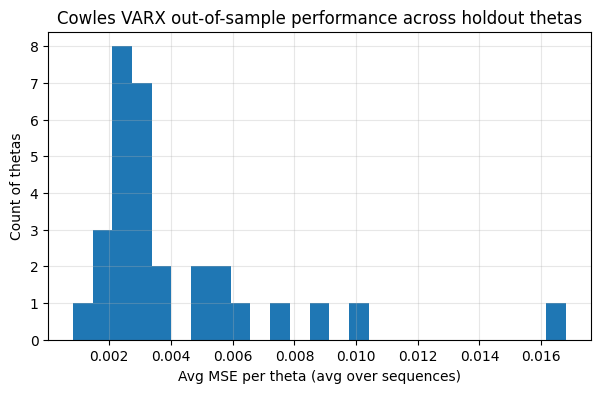

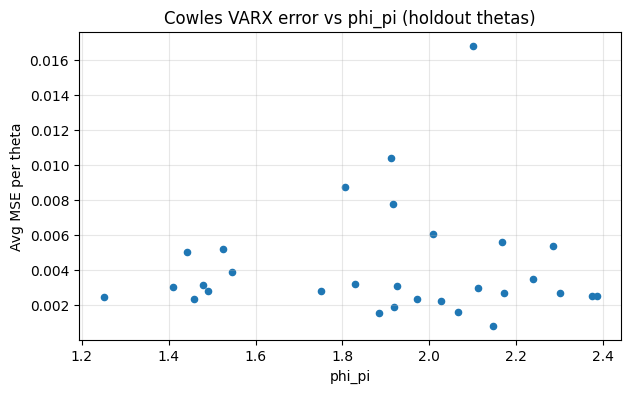

In [ ]:

# --- Distribution of errors across holdout thetas ---
T_eval = 64
n_sequences_per_theta = 5

theta_mses = np.array(
    [theta_avg_mse_varx(varx, p, T=T_eval, n_sequences=n_sequences_per_theta) for p in test_params],
    dtype=np.float64
)

print("Holdout thetas:", len(test_params))
print("Avg MSE per theta: mean =", float(theta_mses.mean()),
      "median =", float(np.median(theta_mses)),
      "p90 =", float(np.quantile(theta_mses, 0.9)))

plt.figure(figsize=(7,4))
plt.hist(theta_mses, bins=25)
plt.title("Cowles VARX out-of-sample performance across holdout thetas")
plt.xlabel("Avg MSE per theta (avg over sequences)")
plt.ylabel("Count of thetas")
plt.grid(True, alpha=0.3)
plt.show()

phi_pi_vals = np.array([p.phi_pi for p in test_params], dtype=np.float64)
plt.figure(figsize=(7,4))
plt.scatter(phi_pi_vals, theta_mses, s=20)
plt.title("Cowles VARX error vs phi_pi (holdout thetas)")
plt.xlabel("phi_pi")
plt.ylabel("Avg MSE per theta")
plt.grid(True, alpha=0.3)
plt.show()


Example 1/3 | MSE=0.005616 | per-var x=0.006703, pi=0.001999, i=0.008148


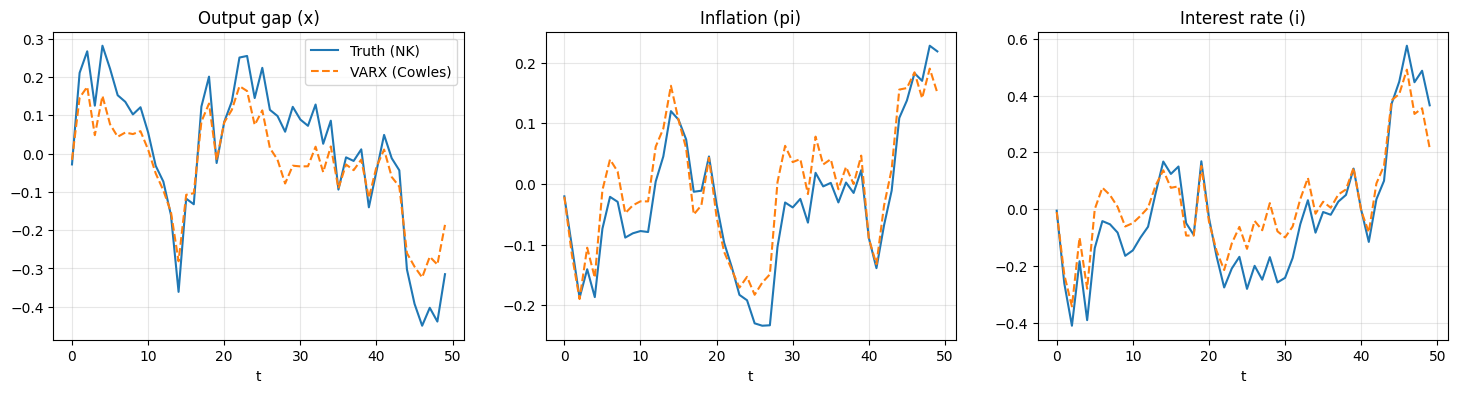

Example 2/3 | MSE=0.001930 | per-var x=0.002220, pi=0.000477, i=0.003092


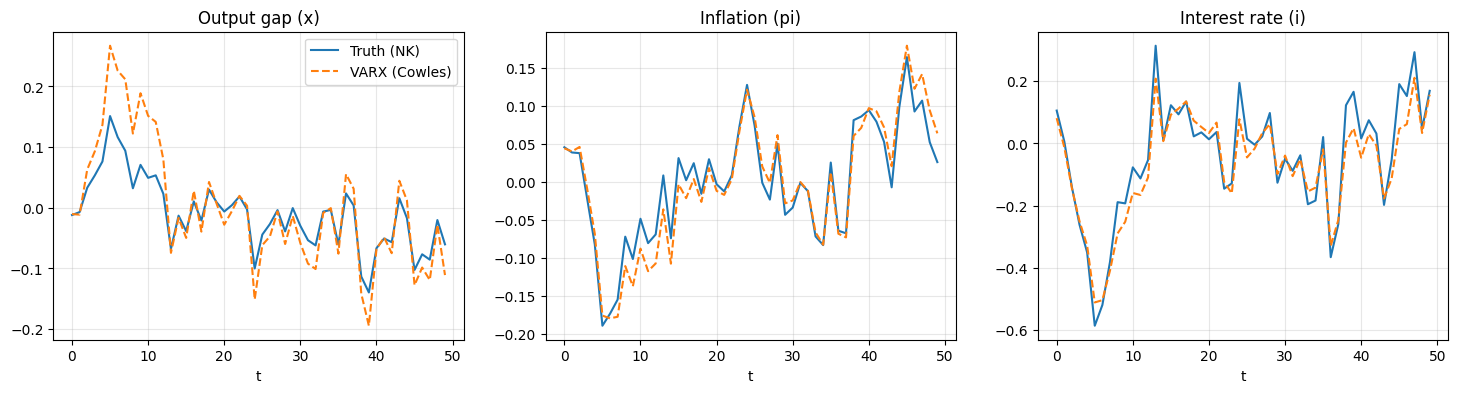

Example 3/3 | MSE=0.003990 | per-var x=0.006317, pi=0.000705, i=0.004948


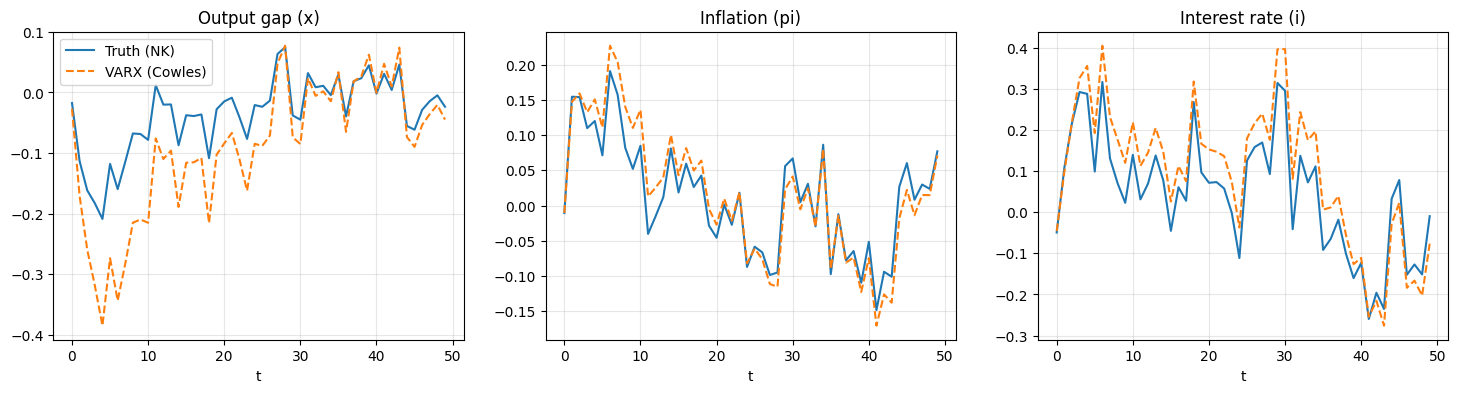

In [ ]:

# --- Qualitative truth vs prediction overlays ---
n_examples = 3
T_plot = 50
names = ["Output gap (x)", "Inflation (pi)", "Interest rate (i)"]

for k in range(n_examples):
    p = random.choice(test_params)
    _, y_true, y_pred = predict_on_params_varx(varx, p, T=T_plot)
    seq_mse = mse(y_true, y_pred)
    per = mse_per_var(y_true, y_pred)
    print(f"Example {k+1}/{n_examples} | MSE={seq_mse:.6f} | per-var x={per[0]:.6f}, pi={per[1]:.6f}, i={per[2]:.6f}")

    t = np.arange(T_plot)
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    for j, ax in enumerate(axes):
        ax.plot(t, y_true[:, j], label="Truth (NK)")
        ax.plot(t, y_pred[:, j], "--", label="VARX (Cowles)")
        ax.set_title(names[j])
        ax.set_xlabel("t")
        ax.grid(True, alpha=0.3)
    axes[0].legend()
    plt.show()


Random holdout theta: NKParams(beta=0.956019417233105, sigma=2.6827446834220625, kappa=0.1313352736201851, phi_pi=2.066898617412381, phi_x=0.46828043246620044, rho_r=0.5557773954785981, rho_u=0.7434813711745236, rho_i=0.7843592694744351)


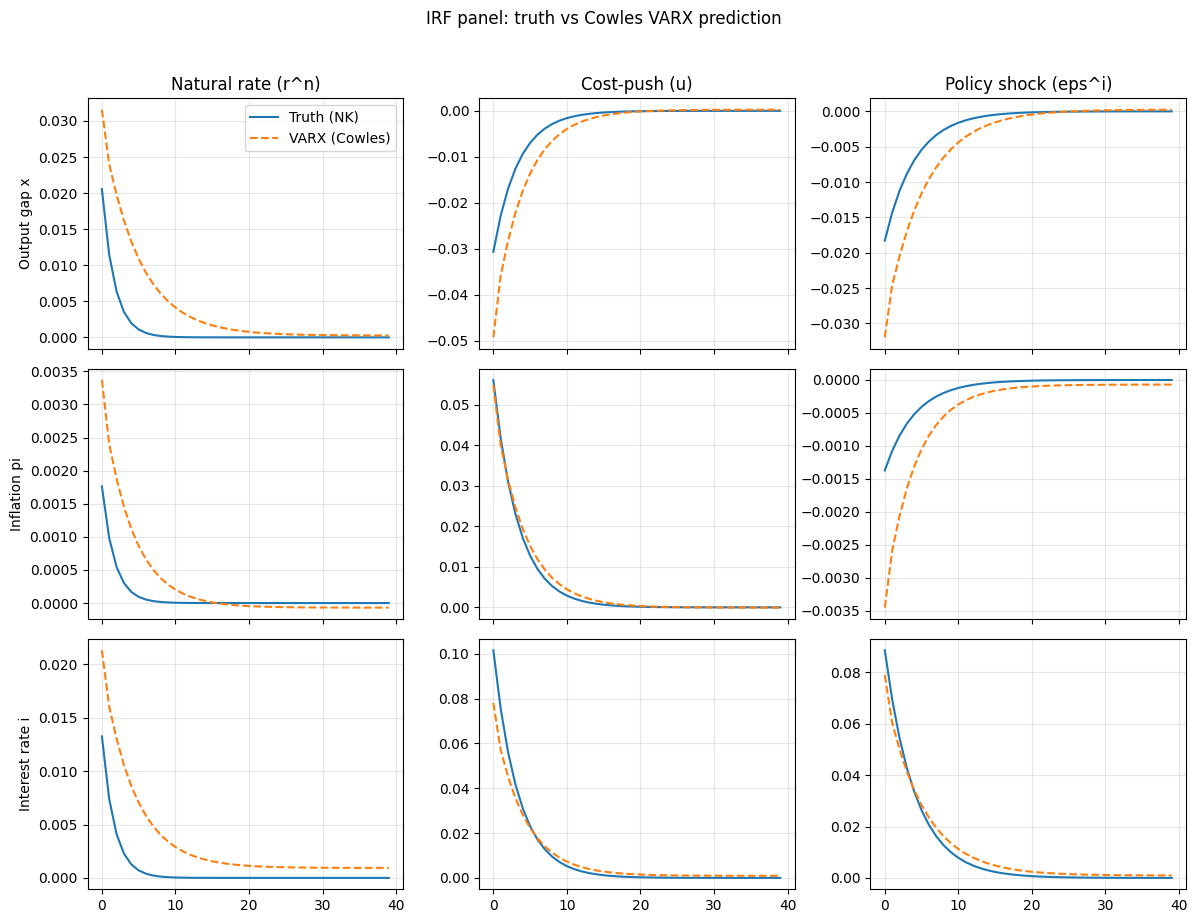

Avg IRF MSE across 3 shocks (for this theta): 0.000013


1.3018111068524064e-05

In [ ]:

# --- IRF panel on a random holdout theta ---
p = random.choice(test_params)
print("Random holdout theta:", p)
plot_irf_panel_varx(varx, p, H=40, impulse=1.0)
